In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'paysim1' dataset.
Path to dataset files: /kaggle/input/paysim1


In [ ]:
import os
file_list = os.listdir(path)
csv_file = [f for f in file_list if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))
display(df.head())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.shape

(6362620, 11)

In [ ]:
df = df.drop(["nameOrig", "nameDest"], axis=1)

In [ ]:
df = pd.get_dummies(df, columns=['type'], drop_first=True) #One-hot encode categorical data

In [ ]:
#Feature Engineering
df['diff_orig_balance'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount'] #Fake deductions or reversals
df['diff_dest_balance'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount'] #Ghost or rerouted deposits
df['balance_change_ratio'] = (df['newbalanceDest'] - df['oldbalanceDest']) / (df['amount'] + 1) #Disproportionate updates or laundering


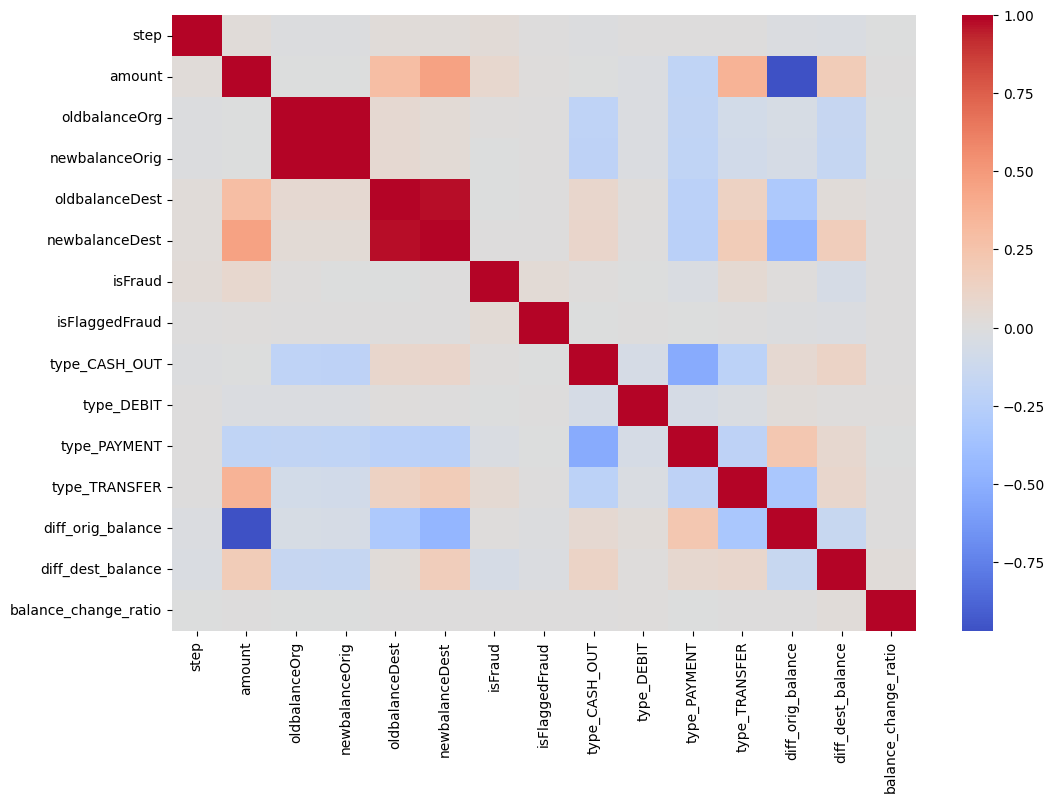

In [ ]:
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

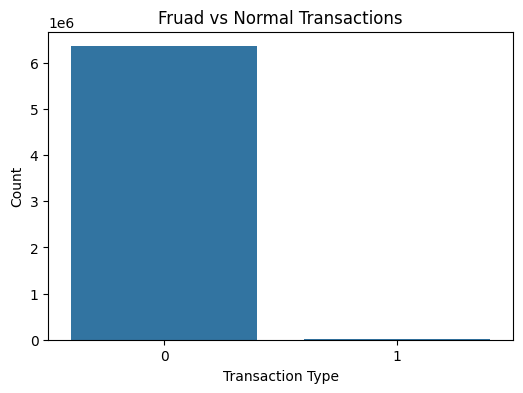

Fraudulent Transactions: 0.13%


In [ ]:
#EDA
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Fruad vs Normal Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')

plt.show()

fraud_rate = df['isFraud'].mean() * 100
print(f"Fraudulent Transactions: {fraud_rate:.2f}%")

/tmp/ipython-input-3016236732.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='amount', data=df, palette='Set2')


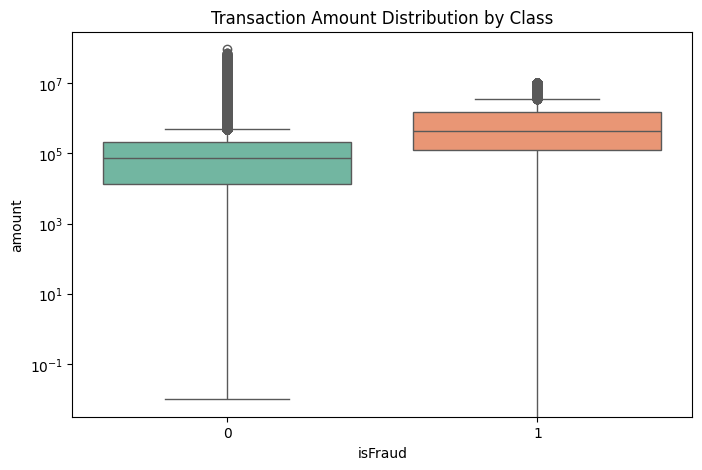

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='isFraud', y='amount', data=df, palette='Set2')
plt.yscale('log')
plt.title('Transaction Amount Distribution by Class')
plt.show()

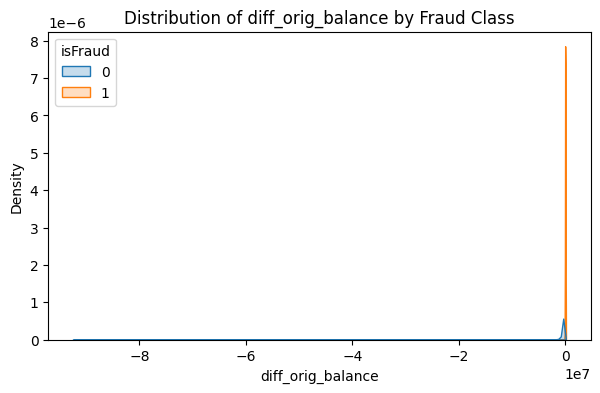

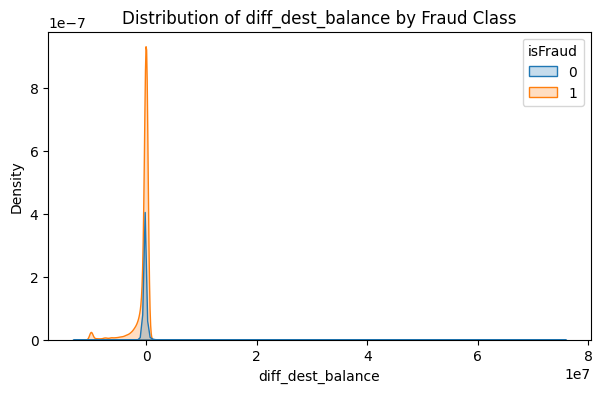

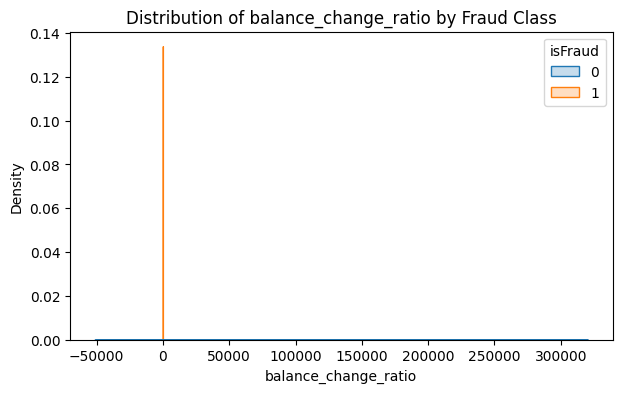

In [ ]:
features = ['diff_orig_balance', 'diff_dest_balance', 'balance_change_ratio']

for col in features:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=df, x=col, hue='isFraud', common_norm=False, fill=True)
    plt.title(f'Distribution of {col} by Fraud Class')
    plt.show()


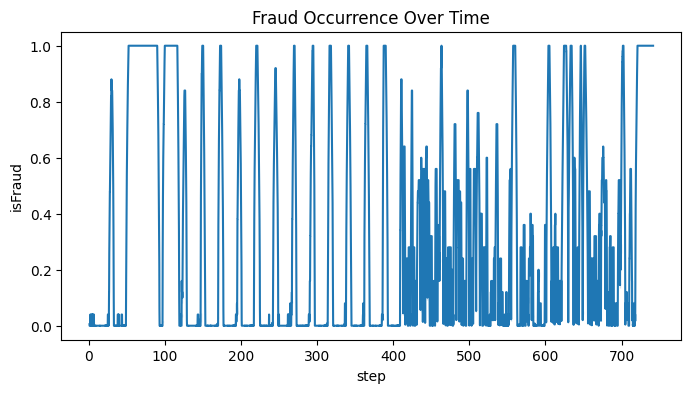

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x='step', y='isFraud', data=df.rolling(50).mean())
plt.title('Fraud Occurrence Over Time')
plt.show()